# GoogLeNet CNN Reproduction
This notebook trains a reproduction of the complex GoogLeNet model.

In [1]:
# Set to True if you want to run Tensorflow on a GPU.
use_gpu = False

if not use_gpu:
    print("Installing Tensorflow with CPU support...")
    !pip install tensorflow
else:
    print("Installing Tensorflow with GPU support...")
    !pip install tensorflow[and-cuda]

Installing Tensorflow with CPU support...


In [2]:
!pip install matplotlib

In [3]:
import tensorflow as tf
import os
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [4]:
# If using the GPU, setting this to True will cause Tensorflow to not allocate all available memory. This will prevent the GPU from running out of memory at the cost of training speed.
enable_memory_growth = False

if use_gpu:
    gpus = tf.config.experimental.list_physical_devices("GPU")
    if gpus:
        print(f"Found {len(gpus)} GPU(s), setting memory growth to {enable_memory_growth}")
        tf.config.experimental.set_memory_growth(gpu, enable_memory_growth)

## Ingesting the input images

### Prepare the ImageNet images
In the same directory as this notebook, you will find a file named `imagenet_224.zip`. This zip file contains the ImageNet images used for training the CNN.
Unzip the files to a folder named `imagenet_224`. The unzipped files will have the following structure:

```
imagenet_224
----airplane
----automobile
----...
----ship
----truck
``` 
If the folder structure doesn't match this, then you will get an error!

In [5]:
IMAGE_DIR = os.path.join(os.getcwd(), "imagenet_224")

if not os.path.exists(IMAGE_DIR):
    raise RuntimeError(
        f"{IMAGE_DIR} not found. You need to download the ImageNet dataset and unzip it into a folder called imagenet_224")

# You can adjust the batch size depending on the compute resources
BATCH_SIZE = 16

IMG_HEIGHT = 224
IMG_WIDTH = 224
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_DIR,           
    validation_split=0.2,     
    subset="training",          
    seed=111,                    
    image_size=TARGET_SIZE,      
    batch_size=BATCH_SIZE              
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_DIR,          
    validation_split=0.2,       
    subset="validation",        
    seed=111,                    
    image_size=TARGET_SIZE,     
    batch_size=BATCH_SIZE              
)

Found 14738 files belonging to 10 classes.
Using 11791 files for training.
Found 14738 files belonging to 10 classes.
Using 2947 files for validation.


## Performance enhancements
Apply augmentation and prefetching to improve training performance.

In [6]:
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

# Apply the augmentation only on the training dataset
train_dataset = train_dataset.map(lambda x, y: (augmentation(x, training=True), y))

# Prefetch the datasets for performance improvement
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Build the CNN

In [15]:
# input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

# There are 10 image classes.
NUM_CLASSES = 10

# Specify a lower learning late because of the small data set.
LEARNING_RATE = 0.0001

def inception_layer(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    """
    Creates an Inception layer that applies multiple convolutions and pooling operations in parallel and concatenates the results.

    The Inception layer performs the following steps in parallel:
    1. A 1x1 convolution with 'filters_1x1' filters.
    2. A 1x1 convolution followed by a 3x3 convolution, where 'filters_3x3_reduce' controls the number of filters in the initial 1x1 convolution, 
       and 'filters_3x3' specifies the number of filters for the 3x3 convolution.
    3. A 1x1 convolution followed by a 5x5 convolution, where 'filters_5x5_reduce' controls the number of filters in the initial 1x1 convolution,
       and 'filters_5x5' specifies the number of filters for the 5x5 convolution.
    4. A 3x3 max pooling operation followed by a 1x1 convolution with 'filters_pool_proj' filters.

    Finally, the outputs of all these parallel operations are concatenated along the channel axis to form the final output.

    Args:
        x (Tensor): Input tensor to the Inception layer.
        filters_1x1 (int): Number of filters for the 1x1 convolution path.
        filters_3x3_reduce (int): Number of filters for the 1x1 convolution before the 3x3 convolution.
        filters_3x3 (int): Number of filters for the 3x3 convolution.
        filters_5x5_reduce (int): Number of filters for the 1x1 convolution before the 5x5 convolution.
        filters_5x5 (int): Number of filters for the 5x5 convolution.
        filters_pool_proj (int): Number of filters for the 1x1 convolution after the max pooling.

    Returns:
        Tensor: Output tensor resulting from concatenating the filters' outputs.
    """
    conv_1x1 = layers.Conv2D(filters_1x1, (1, 1), padding="same", activation="relu")(x)
    
    conv_3x3 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding="same", activation="relu")(x)
    conv_3x3 = layers.Conv2D(filters_3x3, (3, 3), padding="same", activation="relu")(conv_3x3)
    
    conv_5x5 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding="same", activation="relu")(x)
    conv_5x5 = layers.Conv2D(filters_5x5, (5, 5), padding="same", activation="relu")(conv_5x5)
    
    max_pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding="same")(x)
    max_pool = layers.Conv2D(filters_pool_proj, (1, 1), padding="same", activation="relu")(max_pool)
    
    output = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, max_pool], axis=-1)
    
    return output

# Define the full model
def googlenet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    """
    Builds a GoogLeNet Inception model.

    The model consists of the following components:
    1. Initial convolution and max-pooling layers.
    2. Two main convolutional blocks, each followed by max-pooling layers.
    3. Multiple Inception layers that apply parallel convolutional and pooling operations,
       followed by max-pooling layers between certain inception layers.
    4. Global Average Pooling.
    5. Dropout to prevent overfitting.
    6. A final fully connected layer with a softmax activation function.

    Args:
        input_shape (tuple): Shape of the input image.
        num_classes (int): Number of output classes for classification.
    
    Returns:
        keras.Model: A Keras Model instance representing the GoogLeNet architecture.
    """
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    
    x = layers.Conv2D(192, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    
    x = inception_layer(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128,
                         filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32)
    
    x = inception_layer(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192,
                         filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64)
    
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    
    x = inception_layer(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208,
                         filters_5x5_reduce=16, filters_5x5=48, filters_pool_proj=64)
    
    x = inception_layer(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224,
                         filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64)
    
    x = inception_layer(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256,
                         filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64)
    
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs, outputs)
    
    return model

model = googlenet()
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 56, 56,    │          0 │ conv2d_64[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 56, 56,    │    110,784 │ max_pooling2d_18… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 28, 28,    │          0 │ conv2d_65[0][0]   │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 28, 28,    │     18,528 │ max_pooling2d_19… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 28, 28,    │      3,088 │ max_pooling2d_19… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 28, 28,    │          0 │ max_pooling2d_19… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 28, 28,    │     12,352 │ max_pooling2d_19… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 28, 28,    │    110,720 │ conv2d_67[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 28, 28,    │     12,832 │ conv2d_69[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 28, 28,    │      6,176 │ max_pooling2d_20… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 28, 28,    │          0 │ conv2d_66[0][0],  │
│ (Concatenate)       │ 256)              │            │ conv2d_68[0][0],  │
│                     │                   │            │ conv2d_70[0][0],  │
│                     │                   │            │ conv2d_71[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 28, 28,    │     32,896 │ concatenate_10[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 28, 28,    │      8,224 │ concatenate_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 28, 28,    │          0 │ concatenate_10[0… │
│ (MaxPooling2D)      │ 256)              │            │                 

 Total params: 2,013,258 (7.68 MB)

 Trainable params: 2,013,258 (7.68 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [8]:
# You can adjust the number of epochs as needed.
EPOCHS = 30

history = model.fit(
    train_dataset,
    epochs=EPOCHS,                        
    validation_data=validation_dataset
)

737/737 ━━━━━━━━━━━━━━━━━━━━ 329s 441ms/step - accuracy: 0.1854 - loss: 2.5708 - val_accuracy: 0.3264 - val_loss: 1.7776


## Save training artifacts

In [9]:
# Save the model to a file.
model.save(os.path.join(os.getcwd(), "model_googlenet_complex.keras"))

# Save the history to a file.
with open(os.path.join(os.getcwd(), "history_googlenet_complex.pkl"), "wb") as file:
    pickle.dump(history, file)

## Assess the model's performance

### Plot the accuracy curve

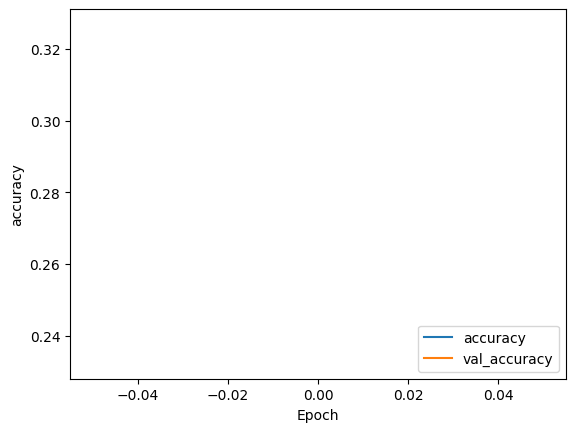

In [10]:
def plot_accuracy_curve(training_result, metric):
    val_metric = f"val_{metric}"
    train_perf = training_result.history[metric]
    validation_perf = training_result.history[val_metric]
    
    plt.plot(train_perf, label=metric)
    plt.plot(validation_perf, label=val_metric)
    
    max_val = max(validation_perf)
    max_val_epoch = validation_perf.index(max_val)
    
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend(loc="lower right")
    
plot_accuracy_curve(history, "accuracy")

## Find the epoch at which the difference in training and validation accuracies are minimized.

In [11]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

acc_diff = [abs(train - val) for train, val in zip(train_acc, val_acc)]

min_diff = min(acc_diff)
min_diff_epoch = acc_diff.index(min_diff) + 1

train_acc_at_min_diff = train_acc[min_diff_epoch - 1]  
val_acc_at_min_diff = val_acc[min_diff_epoch - 1]      

print(f"Minimum difference between accuracy and validation accuracy: {min_diff:.4f} at epoch {min_diff_epoch}")
print(f"Training Accuracy at epoch {min_diff_epoch}: {train_acc_at_min_diff:.4f}")
print(f"Validation Accuracy at epoch {min_diff_epoch}: {val_acc_at_min_diff:.4f}")


Minimum difference between accuracy and validation accuracy: 0.0937 at epoch 1
Training Accuracy at epoch 1: 0.2327
Validation Accuracy at epoch 1: 0.3264


## Evaluate the model on unseen ImageNet images.

### Prepare the evaluation ImageNet images
In the same directory as this notebook, you will find a file named `imagenet_224_eval.zip`. This zip file contains the ImageNet images used for evaluating the CNN.
Unzip the files to a folder named `imagenet_224_eval`. The unzipped files will have the following structure:

```
imagenet_224_eval
----airplane
----automobile
----...
----ship
----truck
``` 
If the folder structure doesn't match this, then you will get an error!

In [12]:
UNSEEN_IMAGENET_IMG_DIR = os.path.join(os.getcwd(), "imagenet_224_eval")

if not os.path.exists(UNSEEN_IMAGENET_IMG_DIR):
    raise RuntimeError(
        f"{UNSEEN_IMAGENET_IMG_DIR} not found. You need to download the ImageNet evaluation dataset and unzip it into a folder called imagenet_224_eval")

eval_imagenet_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    UNSEEN_IMAGENET_IMG_DIR,          
    image_size=TARGET_SIZE,      
    batch_size=BATCH_SIZE             
)

# Prefetch for better performance.
eval_imagenet_dataset = eval_imagenet_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

loss, accuracy = model.evaluate(eval_imagenet_dataset)

print(f"Loss on unseen ImageNet images: {loss:.4f}")
print(f"Accuracy on unseen ImageNet images: {accuracy:.4f}")

Found 1000 files belonging to 10 classes.
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.3421 - loss: 1.7452
Loss on unseen ImageNet images: 1.7557
Accuracy on unseen ImageNet images: 0.3360


## Evaluate the model on CIFAR-10 images.

### Prepare the evaluation CIFAR-10 images
In the same directory as this notebook, you will find a file named `cifar-10.zip`. This zip file contains the ImageNet images used for evaluating the CNN against a totally different dataset - CIFAR-10.
Unzip the files to a folder named `cifar-10`. The unzipped files will have the following structure:

```
cifar-10
----airplane
----automobile
----...
----ship
----truck
``` 
If the folder structure doesn't match this, then you will get an error!

In [13]:
CIFAR10_IMG_DIR = os.path.join(os.getcwd(), "cifar-10")

if not os.path.exists(CIFAR10_IMG_DIR):
    raise RuntimeError(
        f"{CIFAR10_IMG_DIR} not found. You need to download the CIFAR-10 dataset and unzip it into a folder called cifar-10")

eval_cifar_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    CIFAR10_IMG_DIR,           
    image_size=TARGET_SIZE,      
    batch_size=BATCH_SIZE              
)

# Prefetch for better performance.
eval_cifar_dataset = eval_cifar_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

loss, accuracy = model.evaluate(eval_cifar_dataset)

print(f"Loss on CIFAR-10 images: {loss:.4f}")
print(f"Accuracy CIFAR-10 images: {accuracy:.4f}")

Found 10000 files belonging to 10 classes.
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 125ms/step - accuracy: 0.1817 - loss: 2.1963
Loss on CIFAR-10 images: 2.1935
Accuracy CIFAR-10 images: 0.1774
